# DataHacks 2022 Intermediate track - Code for visualization and model

In [185]:
import pandas as pd
import os
import seaborn as sns
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from scipy.sparse import hstack, csr_matrix

## EDA Section

In [187]:
# Read in the data
data = pd.read_csv(os.path.join('data', 'intermediate_trainset.csv'))
data.columns = ['episode', 'business_name', 'business_desc', 'deal', 'deal_shark']

# Processing business name to be uniform and free of punctuation marks
data['name_length'] = data.business_name.apply(lambda x: len(x))
data['desc_length'] = data.business_desc.apply(lambda x: len(x))
data['name_word_len'] = data.business_name.apply(lambda x: len(x.split()))
data['desc_word_len'] = data.business_desc.apply(lambda x: len(x.split()))

data['business_name_processed'] = (
    data.business_name
        .str.lower()
        .str.replace(r"['-.]", '', regex=True)
        .str.replace(r'&', 'and', regex=True)
)

data['business_desc_processed'] = (
    data.business_desc
        .str.lower()
        .str.replace(r"['-.]", '', regex=True)
        .str.replace(r'&', 'and', regex=True)
)

data['season'] = (data['episode'] / 100).astype(int)
data['episode'] = (data['episode'] % 100)

data['episode_bin'] = data.episode.apply(lambda x: np.floor(x / 100) * 100)
data['detailedness'] = data.name_word_len * data.desc_word_len

data

,episode,business_name,business_desc,deal,deal_shark,name_length,desc_length,name_word_len,desc_word_len,business_name_processed,business_desc_processed,season,episode_bin,detailedness
0,26,Laid Brand,hair-care products made with pheromones . Laid...,0,NaN,10,233,2,34,laid brand,haircare products made with pheromones laid b...,8,0.0,68
1,26,Wine & Design,painting classes with wine served . Wine & Des...,1,KOL,13,245,3,38,wine and design,painting classes with wine served wine and de...,8,0.0,114
2,24,Peoples Design,a mixing bowl with a built-in scoop . Peoples ...,1,LG,14,284,2,44,peoples design,a mixing bowl with a builtin scoop peoples de...,8,0.0,88
3,24,Rumi Spice,saffron imported from Afghanistan . Rumi Spice...,1,MC,10,238,2,37,rumi spice,saffron imported from afghanistan rumi spice ...,8,0.0,74
4,24,Wallet Buckle,a belt buckle that holds credit cards . The Wa...,1,RH,13,195,2,36,wallet buckle,a belt buckle that holds credit cards the wal...,8,0.0,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525,2,Sticky Note Holder,a Post-It note arm for laptops . a Post-It not...,0,NaN,18,63,3,13,sticky note holder,a postit note arm for laptops a postit note a...,1,0.0,39
526,1,College Foxes Packing Boxes,a packing and organizing service based on an a...,0,NaN,27,260,4,39,college foxes packing boxes,a packing and organizing service based on an a...,1,0.0,156
527,1,Ionic Ear,an implantable Bluetooth device requiring surg...,0,NaN,9,158,2,24,ionic ear,an implantable bluetooth device requiring surg...,1,0.0,48
528,1,Mr. Tod's Pie Factory,a pie company,1,BC+DJ,21,14,4,3,mr tods pie factory,a pie company,1,0.0,12


<AxesSubplot:xlabel='season', ylabel='detailedness'>

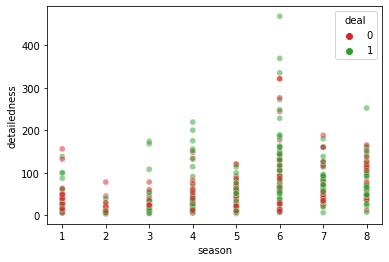

In [188]:
sns.scatterplot(data=data, x='season', y='detailedness', hue='deal', alpha=.5, palette={0:'tab:red', 1:'tab:green'})

<AxesSubplot:ylabel='Frequency'>

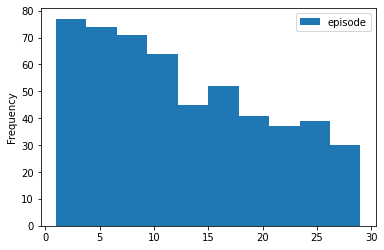

In [189]:
data.plot(kind='hist', x='deal', y='episode', stacked=True)

This notebook is meant for testing multiple machine learning models in the Datahacks 2022 Intermediate Track.

In [150]:
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

In [151]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alexa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [152]:
stop = stopwords.words('english')

In [153]:
sharktank = pd.read_csv(os.path.join('data', 'intermediate_trainset.csv')).drop(columns=['Deal_Shark'])
sharktank['Pitched_Business_Identifier'] = (
    sharktank.Pitched_Business_Identifier
        .str.lower()
        .str.replace(r"['-.\"]", '', regex=True)
        .str.replace(r'&', 'and', regex=True)
)

sharktank['Pitched_Business_Desc'] = (
    sharktank['Pitched_Business_Desc']
        .str.lower()
        .str.replace(r"['-.\"]", '', regex=True)
        .str.replace(r'&', 'and', regex=True)
        .str.replace(r'\s+a\s+', ' ', regex=True)
        .str.replace(r'\s+an\s+', ' ', regex=True)
        .str.replace(r'^a\s', '', regex=True)
        .str.replace(r'^an\s', '', regex=True)
)

sharktank['Pitched_Business_Desc'] = (
    sharktank.Pitched_Business_Desc
        .apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
)

In [154]:
sharktank

,Season_Epi_code,Pitched_Business_Identifier,Pitched_Business_Desc,Deal_Status
0,826,laid brand,haircare products made pheromones laid brand â...,0
1,826,wine and design,painting classes wine served wine design provi...,1
2,824,peoples design,mixing bowl builtin scoop peoples designs scoo...,1
3,824,rumi spice,saffron imported afghanistan rumi spice offers...,1
4,824,wallet buckle,belt buckle holds credit cards wallet buckle m...,1
...,...,...,...,...
525,102,sticky note holder,postit note arm laptops postit note arm laptops,0
526,101,college foxes packing boxes,packing organizing service based already succe...,0
527,101,ionic ear,implantable bluetooth device requiring surgery...,0
528,101,mr tods pie factory,pie company,1


In [155]:
sharktank['detailedness'] = (
    sharktank.Pitched_Business_Desc.apply(lambda x: len(x.split())) *
    sharktank.Pitched_Business_Identifier.apply(lambda x: len(x.split()))
)

In [156]:
y_labels = sharktank.Deal_Status
x = sharktank.drop(columns=['Deal_Status'])
x

,Season_Epi_code,Pitched_Business_Identifier,Pitched_Business_Desc,detailedness
0,826,laid brand,haircare products made pheromones laid brand â...,50
1,826,wine and design,painting classes wine served wine design provi...,72
2,824,peoples design,mixing bowl builtin scoop peoples designs scoo...,60
3,824,rumi spice,saffron imported afghanistan rumi spice offers...,48
4,824,wallet buckle,belt buckle holds credit cards wallet buckle m...,42
...,...,...,...,...
525,102,sticky note holder,postit note arm laptops postit note arm laptops,24
526,101,college foxes packing boxes,packing organizing service based already succe...,116
527,101,ionic ear,implantable bluetooth device requiring surgery...,30
528,101,mr tods pie factory,pie company,8


In [157]:
# Pipeline for transforming features
def feature_transform(business_id_trans, business_desc_trans, features):
    # Transform the features respectively
    id_vector = business_id_trans.transform(features['Pitched_Business_Identifier'])
    desc_vector = business_desc_trans.transform(features['Pitched_Business_Desc'])
    #print(type(id_vector))
    #print(desc_vector)
    final_vector = hstack([id_vector, desc_vector, csr_matrix(features.detailedness).transpose()])
    return final_vector

# General column transformer for model selection
id_pipe = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tf-idf', TfidfTransformer())
])

desc_pipe = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tf-idf', TfidfTransformer())
])

x_train, x_test, y_train, y_test = train_test_split(x, y_labels, test_size=.2, shuffle=True)
id_pipe.fit_transform(x_train.Pitched_Business_Identifier)
desc_pipe.fit_transform(x_train.Pitched_Business_Desc)

x_train_features = feature_transform(id_pipe, desc_pipe, x_train)
x_train_features

<424x4129 sparse matrix of type '<class 'numpy.float64'>'
	with 7604 stored elements in COOrdinate format>

In [158]:
#Models we wish to try out
from sklearn.naive_bayes import MultinomialNB

In [159]:
naive_model = MultinomialNB()
naive_model.fit(x_train_features, y_train)

MultinomialNB()

In [160]:
np.mean(y_test == naive_model.predict(feature_transform(id_pipe, desc_pipe, x_test)))

0.5660377358490566

In [161]:
from sklearn.neighbors import KNeighborsClassifier
# Kneighbors classifier
knn = KNeighborsClassifier(n_neighbors=4).fit(x_train_features, y_train)
np.mean(y_test == knn.predict(feature_transform(id_pipe, desc_pipe, x_test)))

0.49056603773584906

In [162]:
from sklearn.linear_model import SGDClassifier
# Attempt to create a svm model instead
svm_model = SGDClassifier().fit(x_train_features, y_train)

In [163]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression().fit(x_train_features, y_train)

# Model Evaluations

In [164]:
from sklearn.metrics import confusion_matrix, f1_score

In [165]:
models = [naive_model, svm_model, log_model, knn]
labels = ['Naive Bayes', 'SVM', 'Logistic Regression', 'KNearestNeighbors']
acc_scores = {k:[] for k in labels}
f1_scores = {k:[] for k in labels}
base_pred = []
for _ in range(100):
    x_train, x_test, y_train, y_test = train_test_split(x, y_labels, test_size=.2, shuffle=True)
    id_pipe.fit(x_train.Pitched_Business_Identifier)
    desc_pipe.fit(x_train.Pitched_Business_Desc)
    x_train_features = feature_transform(id_pipe, desc_pipe, x_train)
    base_pred.append(y_test.mean())
    for model, label in zip(models, labels):
        # Fit model
        model.fit(x_train_features, y_train)
        predictions = model.predict(feature_transform(id_pipe, desc_pipe, x_test))
        accuracy = np.mean(y_test == predictions)
        f1 = f1_score(y_test, predictions)
        
        acc_scores[label].append(accuracy)
        f1_scores[label].append(f1)
        
                       
for label in labels:
    print(f"Model: {label}")
    print("Accuracy: "+ str(np.mean(acc_scores[label])))
    print('F1-score: ' + str(np.mean(f1_scores[label])))
    print()
    



Model: Naive Bayes
Accuracy: 0.5367924528301886
F1-score: 0.6949859567562577

Model: SVM
Accuracy: 0.5146226415094339
F1-score: 0.3999114806950127

Model: Logistic Regression
Accuracy: 0.5382075471698112
F1-score: 0.5998424583267377

Model: KNearestNeighbors
Accuracy: 0.49047169811320757
F1-score: 0.43957434134376205



In [166]:
# Aggregation into just number points
for key in f1_scores:
    f1_scores[key] = np.mean(f1_scores[key])
    

In [167]:
for key in acc_scores:
    acc_scores[key] = np.mean(acc_scores[key])

In [168]:
np.mean(base_pred)

0.5334905660377358

In [169]:
test_results = pd.DataFrame(data={
    'Accuracy': acc_scores,
    'F1 Score': f1_scores
})
test_results

,Accuracy,F1 Score
Naive Bayes,0.536792,0.694986
SVM,0.514623,0.399911
Logistic Regression,0.538208,0.599842
KNearestNeighbors,0.490472,0.439574


<AxesSubplot:title={'center':'Model Accuracy'}, ylabel='Model'>

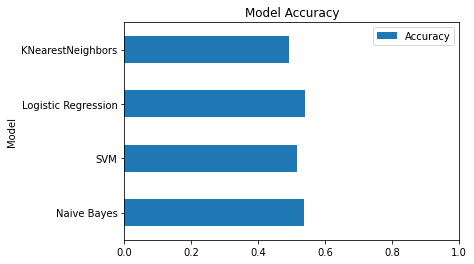

In [183]:
test_results.plot(kind='barh', y='Accuracy', title='Model Accuracy', ylabel='Model', xlim=[0, 1])

<AxesSubplot:title={'center':'Model F1 Score'}, ylabel='Model'>

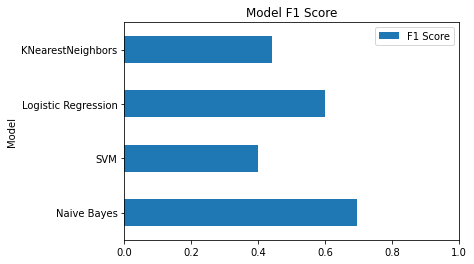

In [171]:
test_results.plot(kind='barh', y='F1 Score', title='Model F1 Score', xlabel='Model', xlim=[0,1])

## Competition Predictions

In [172]:
id_pipe.fit(x.Pitched_Business_Identifier)
desc_pipe.fit(x.Pitched_Business_Desc)
training_features = feature_transform(id_pipe, desc_pipe, x)

In [173]:
naive_model.fit(training_features, y_labels)

MultinomialNB()

In [174]:
np.mean(y_labels == naive_model.predict(feature_transform(id_pipe, desc_pipe, x)))

0.7018867924528301

In [175]:
# Load in test set
test_set = pd.read_csv(os.path.join('data', 'intermediate_testset.csv'))
test_set

test_set['Pitched_Business_Identifier'] = (
    test_set.Pitched_Business_Identifier
        .str.lower()
        .str.replace(r"['-.\"]", '', regex=True)
        .str.replace(r'&', 'and', regex=True)
)

test_set['Pitched_Business_Desc'] = (
    test_set['Pitched_Business_Desc']
        .str.lower()
        .str.replace(r"['-.\"]", '', regex=True)
        .str.replace(r'&', 'and', regex=True)
        .str.replace(r'\s+a\s+', ' ', regex=True)
        .str.replace(r'\s+an\s+', ' ', regex=True)
        .str.replace(r'^a\s', '', regex=True)
        .str.replace(r'^an\s', '', regex=True)
)

# Create new feature for detailedness
test_set['detailedness'] = (
    test_set.Pitched_Business_Desc.apply(lambda x: len(x.split())) *
    test_set.Pitched_Business_Identifier.apply(lambda x: len(x.split()))
)


In [176]:
predictions = naive_model.predict(feature_transform(id_pipe, desc_pipe, test_set))

In [177]:
# Put predictions into csv
prediction_set = pd.DataFrame(data=predictions, columns=['Deal_Status'])
prediction_set

,Deal_Status
0,1
1,1
2,1
3,1
4,1
...,...
171,1
172,1
173,1
174,1


In [178]:
np.mean(predictions)

0.9943181818181818

In [179]:
np.sum(predictions)

175

In [180]:
predictions

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int64)

In [181]:
# Export dataset
with open(os.path.join('data', 'predictions.csv'), 'w', encoding='utf-8', newline='') as output:
    output.write(prediction_set.to_csv(index=False, mode='a'))

In [182]:
pd.read_csv(os.path.join('data', 'predictions.csv'))

,Deal_Status
0,1
1,1
2,1
3,1
4,1
...,...
171,1
172,1
173,1
174,1
